## 🧠 Experiment Overview — Multivariate VMD on Real MEG Data

### 🎯 Objective
This notebook investigates the results of **Multivariate Variational Mode Decomposition (MVMD)** applied to **real MEG recordings** to perform a simultaneous decomposition of all channels. The primary goals are to:
- Decompose the **multi-channel MEG signal** into a set of spatially and spectrally coherent **Multivariate Modes**.
- Characterize the **shared oscillatory modes** across the brain.
- Analyze the **envelopes** of these shared modes to detect functional subgroups.
- Quantify the **multifractal** properties of the enveloppes.

The results serve as the multivariate extension of the channel-by-channel **VMD analysis** performed in the previous notebook.


### ⚙️ Dataset
- **Source:** Resting-state MEG recording (`sub-01_ses-01_task-rest_proc-filt_raw.fif`)
- **Channels:** 306 MEG sensors
- **Sampling frequency:** 250 Hz
- **Duration:** 300 seconds (approx. 82,500 samples)

The dataset provides realistic neural dynamics for validating the MVMD's behavior in extracting **spatially coherent oscillatory components** from real-world conditions.


### 🧩 Processing Pipeline
1.  **Signal Loading and Exploration:**
    - Load the raw MEG data using `mne` and pick only MEG channels.
    - Initial inspection of the data shape and sampling frequency.

2.  **Loading MVMD Decomposition Results (Analysis Focus):**
    - **Crucially:** The **Multivariate Variational Mode Decomposition (MVMD)** code is located in the `notebooks_gpu` directory and **requires GPU resources** due to its computational intensity.
    - This current notebook (`02_mvmd_on_realdata_pipeline.ipynb`) focuses solely on the **analysis** of the pre-computed decomposition results.
    - Load the pre-computed **MVMD modes** from the `.npz` file located in `../results/real/MVMD/modes/mvmd_modes_sub-01.npz`.
    - The loaded data includes the modes, $u$ (shape: $K \times T \times C$), and the central frequencies, $\omega$ (shape: $K$).
    - **Frequency Alignment:** Inspect the central frequencies ($\omega$) to identify groups of modes that are aligned around specific frequencies, corresponding to established **physiological bands** (e.g., $\delta$, $\theta$, $\alpha$, $\beta$).

3.  **Envelope Correlation & Subgroup Detection:**
    - Extract the **amplitude envelopes** for each mode across all channels.
    - Compute **correlation matrices** for the envelopes *within each frequency-aligned MVMD mode group*, revealing **amplitude-coupling structure**.

4.  **Multifractal Analysis (MFA):**
    - Apply **wavelet p-leader multifractal analysis** to the **envelope centroids** of the identified **physiological bands**.


### 🔍 Expected Insights
- Evaluate how effectively **MVMD isolates canonical frequency bands** with **spatial coherence** from real MEG data.
- Characterize the **physiological band** associated with each group of modes that shares an oscillatory frequency.
- Relate **multifractal properties** of the envelope fluctuations to physiological rhythms and brain criticality.


### 📁 Key Outputs
- Decomposed modes saved under `../results/real/MVMD/modes/mvmd_modes_sub-01.npz`
- Envelopes for all channels and modes saved under `../results/real/MVMD/envelopes/meg_channel_XXX_envelopes.npy`
- Correlation matrices for envelope analysis.
- MFA spectrum and log cumulants summaries

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import mne
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from plotting import *
from extract_envelopes import *
from mvmd_utils import * 
from mfa_utils import *

##  **1. Signal Loading and Exploration:**


In [14]:
raw = mne.io.read_raw_fif("../data/sub-01_ses-01_task-rest_proc-filt_raw.fif", preload=True)
raw = raw.copy().pick('meg')
data = raw.get_data()  # shape: (n_channels, n_times)
sfreq = raw.info["sfreq"]
print("sfreq",sfreq)
print("Shape:", data.shape)  # Should be (306, 82500) or similar

Opening raw data file ../data/sub-01_ses-01_task-rest_proc-filt_raw.fif...
    Range : 34500 ... 116999 =    138.000 ...   467.996 secs
Ready.
Reading 0 ... 82499  =      0.000 ...   329.996 secs...
sfreq 250.0
Shape: (306, 82500)


##  **2. Signal exploration:**


In [15]:
sfreq = raw.info["sfreq"]
print("sfreq",sfreq)
print("Shape:", data.shape)  # Should be (306, 82500) or similar

sfreq 250.0
Shape: (306, 82500)


In [16]:
n_channels, n_samples = data.shape
fs = 250

##  **3. MVMD Results Analysis:**


In [17]:
# === Load saved modes after mvmd decomposition
# the mvmd decomposition run on another notebook on google colab cuz it requires GPU
# Please dont hesitate to reach out if you want the decomposition result or the code 
data_modes = np.load("../results/real/MVMD/modes/mvmd_modes_sub-01.npz")
u = data_modes["u"]        # shape: (K, T, C)
omega = data_modes["omega"]  # shape: (K,)

In [18]:
omega = omega.reshape(1, -1)  # shape becomes (1, 5)
omega.shape

(1, 5)

In [19]:
n_modes, T, C = u.shape
#eps = 1e-10
nperseg = min(1024, T)

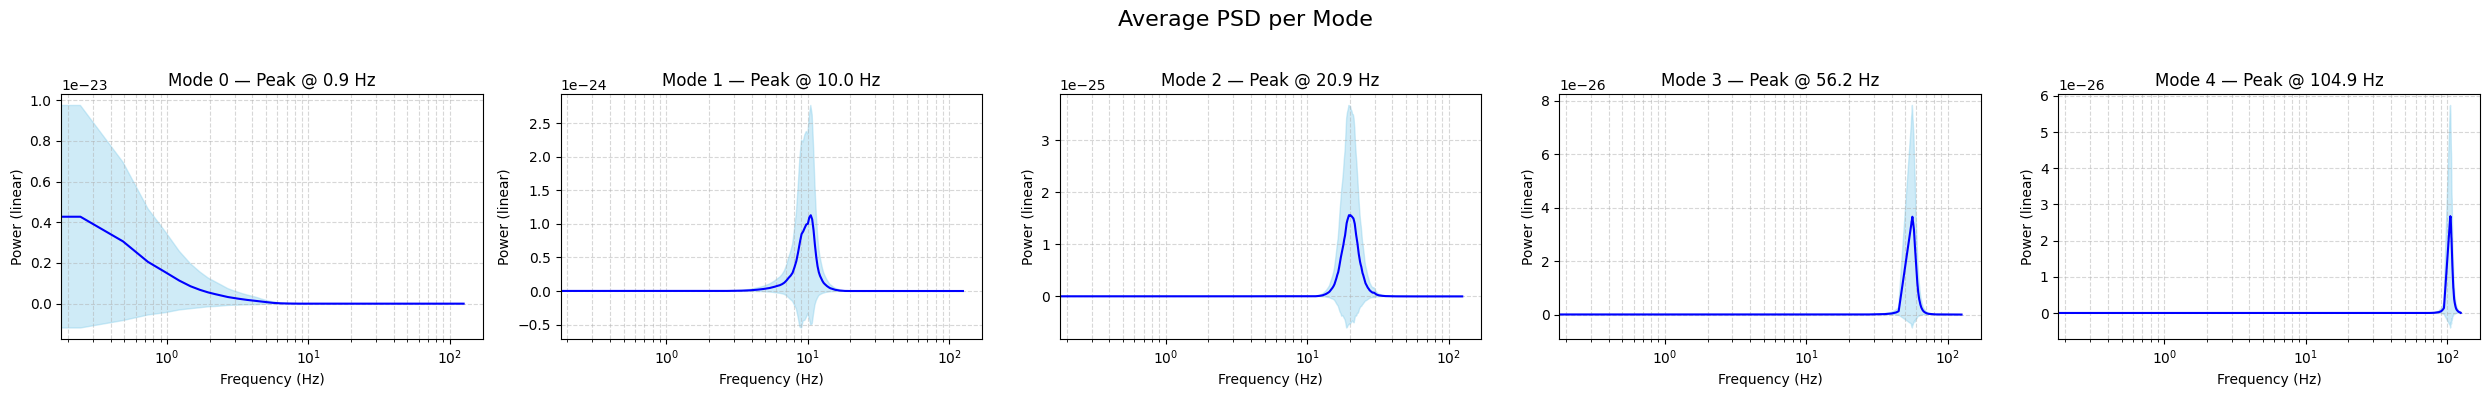

In [20]:
mvmd_plot_mean_mode_psds(
    modes=u,
    sfreq=fs,
    omega=omega,
    standardize=False,
    notch=True,
    scale='linear',         # or 'db'
    layout='horizental',      
    suptitle="Average PSD per Mode"
)


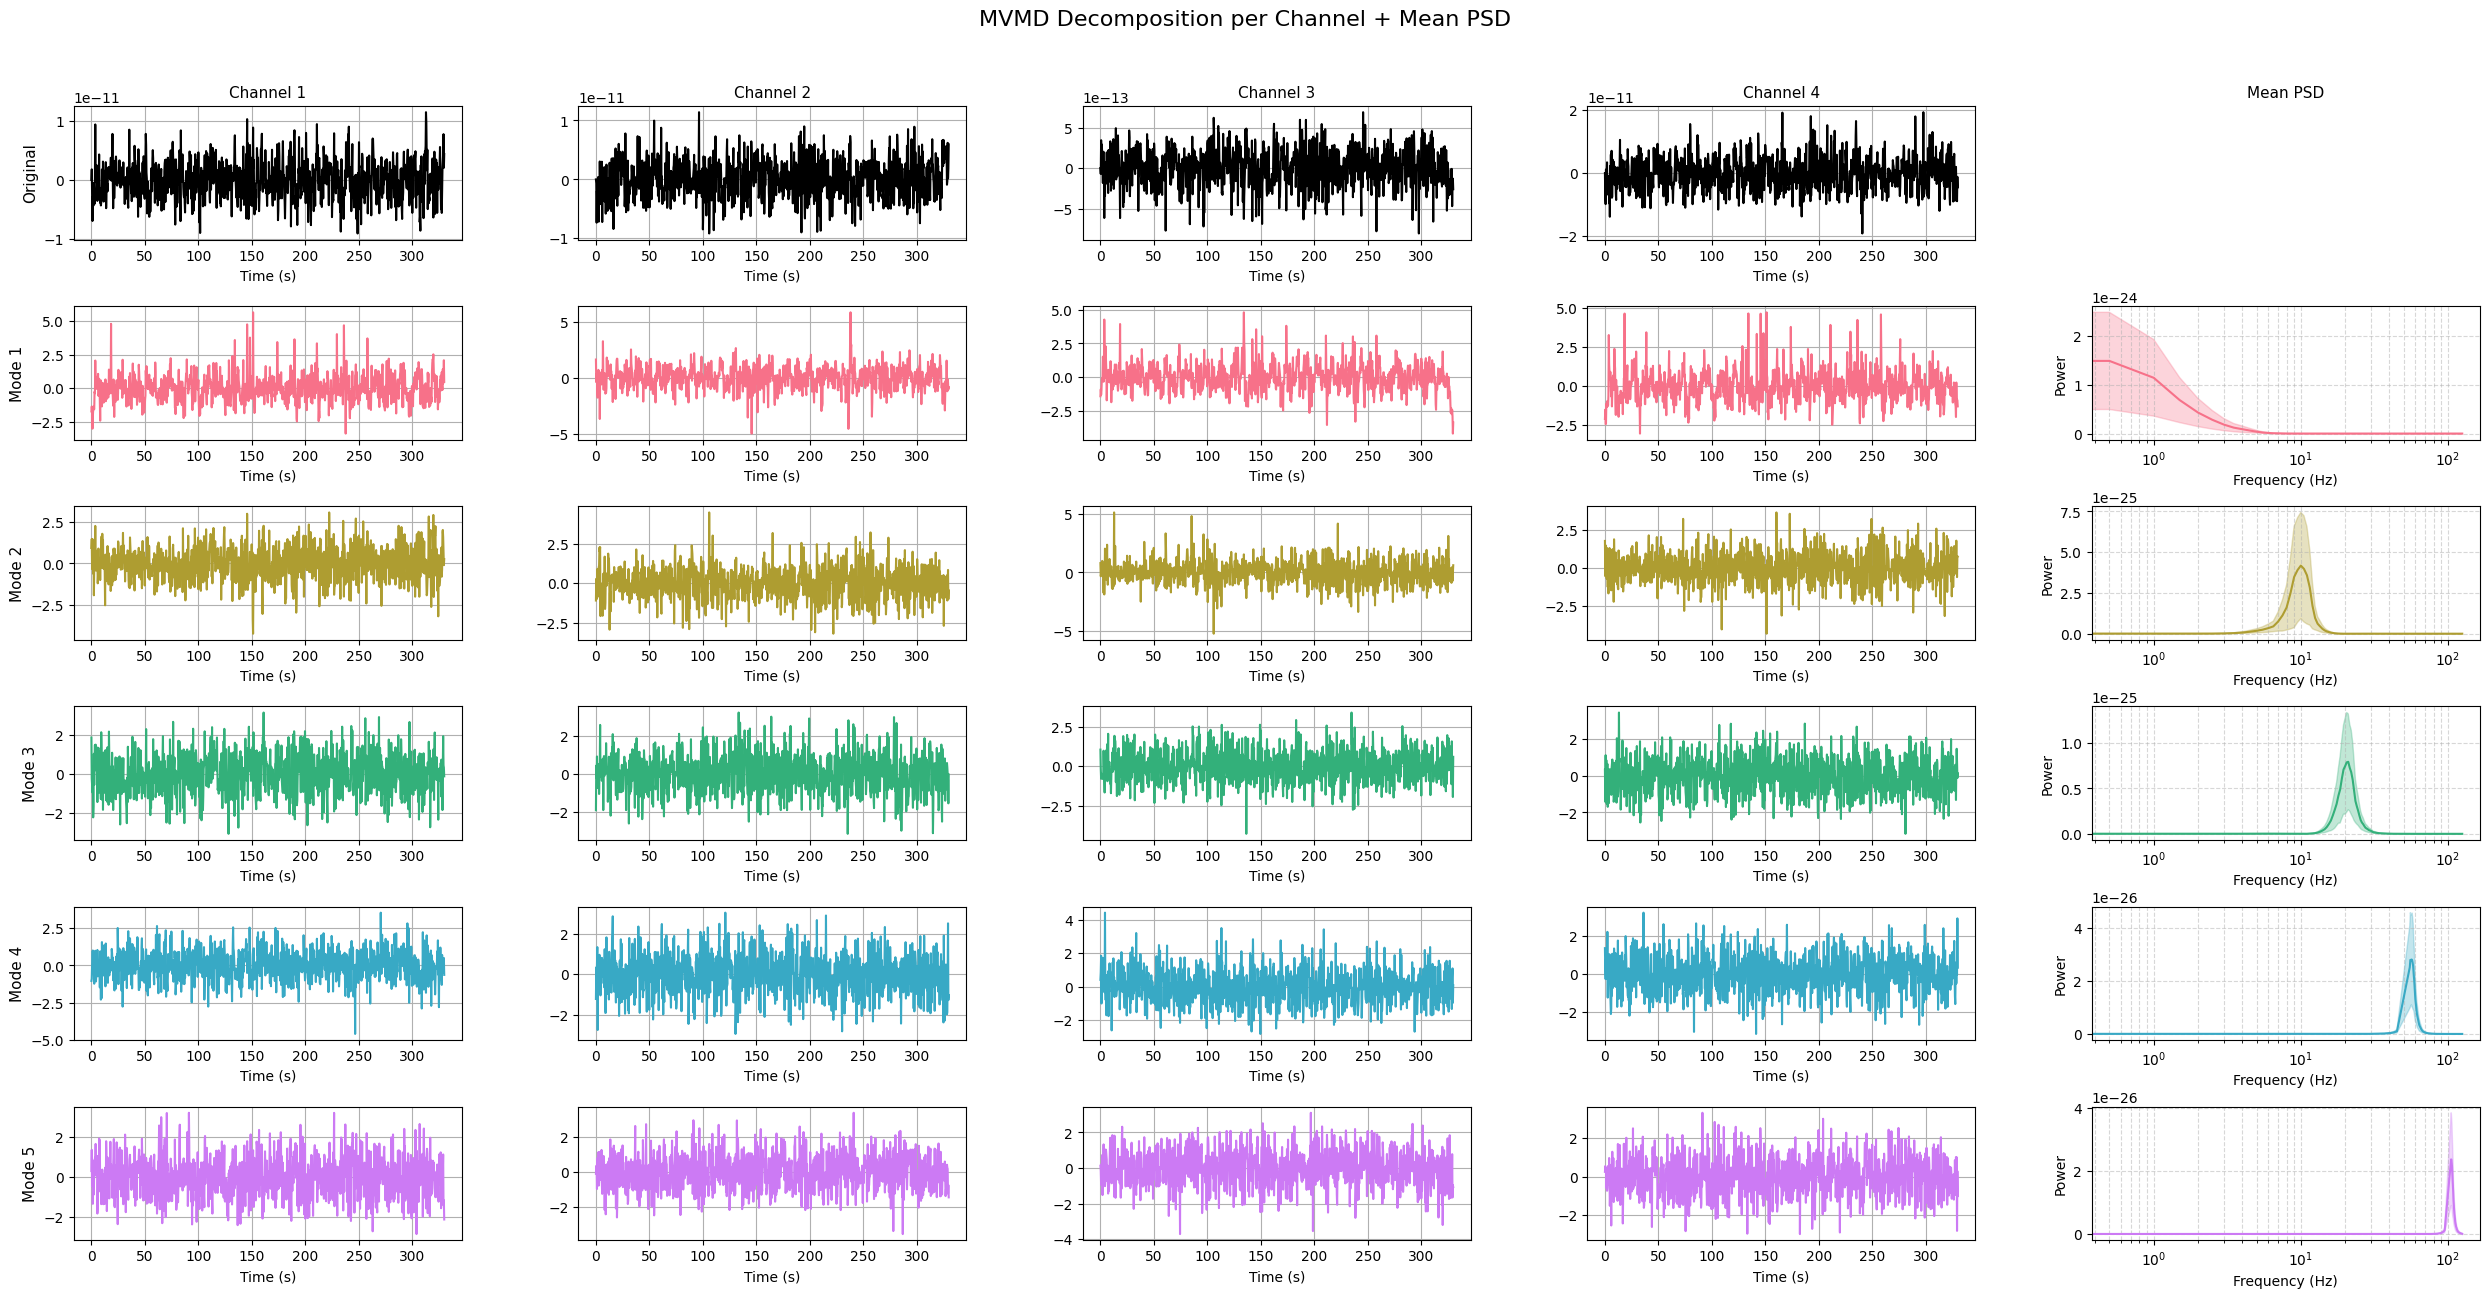

In [21]:
plot_mvmd_grid(
    original=data,
    modes=u,
    omega=omega,
    fs=250,  # or your actual sampling rate
    selected_channels=[1,2,3,4],  # or any list of channel names
    max_points=1000,
    duration=330,  # or None to plot all
    standardize_time=True,
    standardize_psd=False,
    notch=True,
    eps=0,
    log_psd=False,   # or False for linear scale
    log_freq=True   # or False if you want linear freq
)


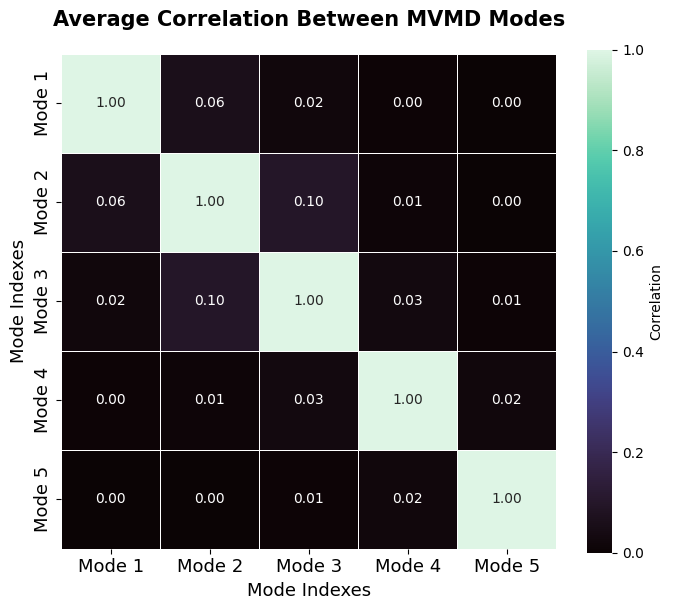

In [28]:
corr_matrix = compute_mode_corr_matrix_across_channels(u)

plot_mode_corr_matrix(
    corr_matrix,
    title="Average Correlation Between MVMD Modes",
    cmap="mako",  # Try "viridis", "mako", or "plasma" too
    mode_names=[f"Mode {i+1}" for i in range(u.shape[0])],
    fontsize=13
)


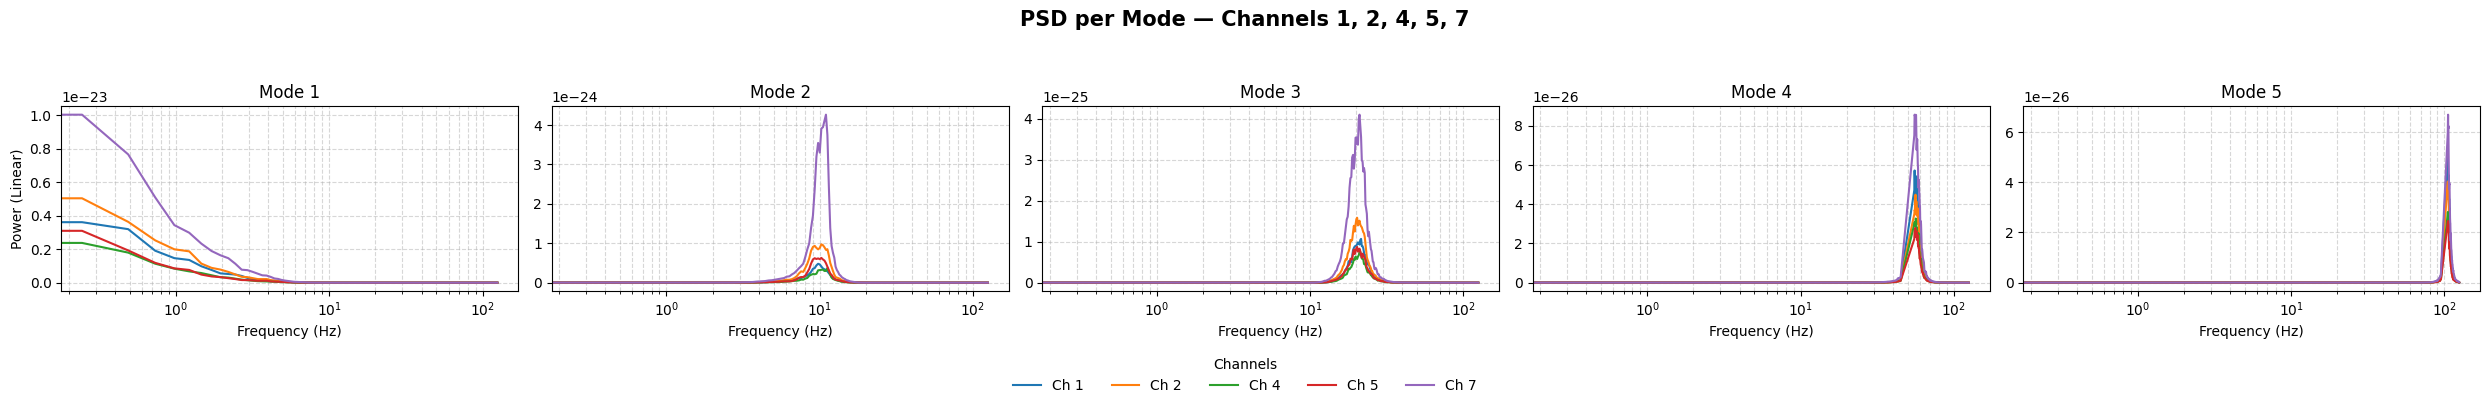

In [29]:

plot_mode_psds_multi_channel_modes_first(
    modes=u,
    sfreq=250,
    channel_indices=[1, 2,4,5,7],
    db_scale=False,
    standardize_psd=False,
    notch=True,
    log_scale=True,
    eps=0
)


##  **4. Enveloppes Extraction:**


In [30]:
omega.real

array([[  0.8732198,   9.975346 ,  20.900143 ,  56.230385 , 104.93458  ]],
      dtype=float32)

In [31]:
omega

array([[  0.8732198+0.j,   9.975346 +0.j,  20.900143 +0.j,
         56.230385 +0.j, 104.93458  +0.j]], dtype=complex64)

In [32]:
# u shape: (n_modes, n_samples, n_channels)
# omega: torch tensor or np.ndarray already in Hz
extract_mvmd_envelopes(
    u=u,  # your MVMD output (n_modes, n_samples, n_channels)
    omega=omega,  # already multiplied by sfreq
    save_dir="../results/real/MVMD/envelopes",  # wherever you want
    sfreq=250
)


✅ Omega (Hz): [  0.8732198   9.975346   20.900143   56.230385  104.93458  ] | Shape: (5,)
🔍 Processing channel 0...
✅ Saved envelopes for channel 0 to ../results/real/MVMD/envelopes/meg_channel_0_envelopes.npy
🔍 Processing channel 1...
✅ Saved envelopes for channel 1 to ../results/real/MVMD/envelopes/meg_channel_1_envelopes.npy
🔍 Processing channel 2...
✅ Saved envelopes for channel 2 to ../results/real/MVMD/envelopes/meg_channel_2_envelopes.npy
🔍 Processing channel 3...
✅ Saved envelopes for channel 3 to ../results/real/MVMD/envelopes/meg_channel_3_envelopes.npy
🔍 Processing channel 4...
✅ Saved envelopes for channel 4 to ../results/real/MVMD/envelopes/meg_channel_4_envelopes.npy
🔍 Processing channel 5...
✅ Saved envelopes for channel 5 to ../results/real/MVMD/envelopes/meg_channel_5_envelopes.npy
🔍 Processing channel 6...
✅ Saved envelopes for channel 6 to ../results/real/MVMD/envelopes/meg_channel_6_envelopes.npy
🔍 Processing channel 7...
✅ Saved envelopes for channel 7 to ../result

In [33]:
envelopes = load_all_envelopes("../results/real/MVMD/envelopes")

[autoreload of mvmd_utils failed: Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/mfa-internship/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/mfa-internship/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/mfa-internship/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/sabrinebendimerad/Downloads/mfa-internship/src/mvmd_utils.py", line 185, in <module>
    modes_df = build_modes_df_mvmd(
  File "/Users/sabrinebendimerad/Downloads/mfa

In [34]:
# envelopes shape should be (n_modes, n_timepoints, n_channels)
correlation_matrices = compute_envelope_correlation_per_mode(envelopes)

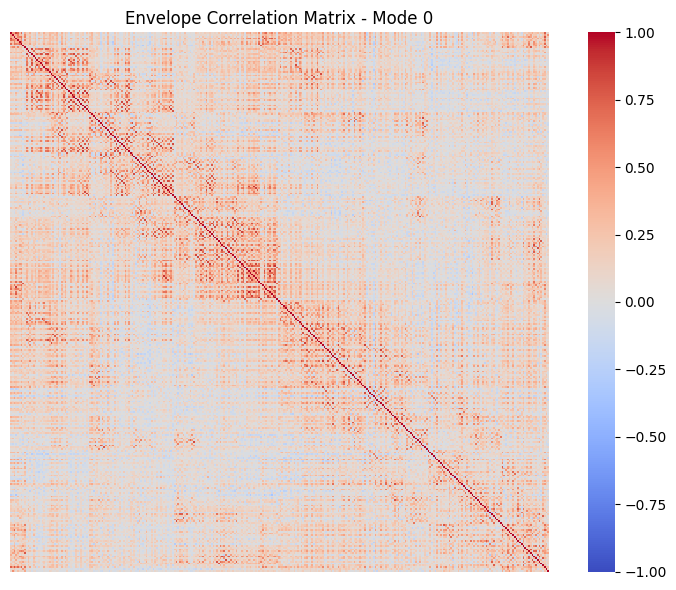

NameError: name 'mode_indices' is not defined

In [37]:
# Display each mode's correlation matrix
for mode_idx, corr in correlation_matrices.items():
    mvmd_plot_correlation_matrix_enveloppe(corr, mode_idx)




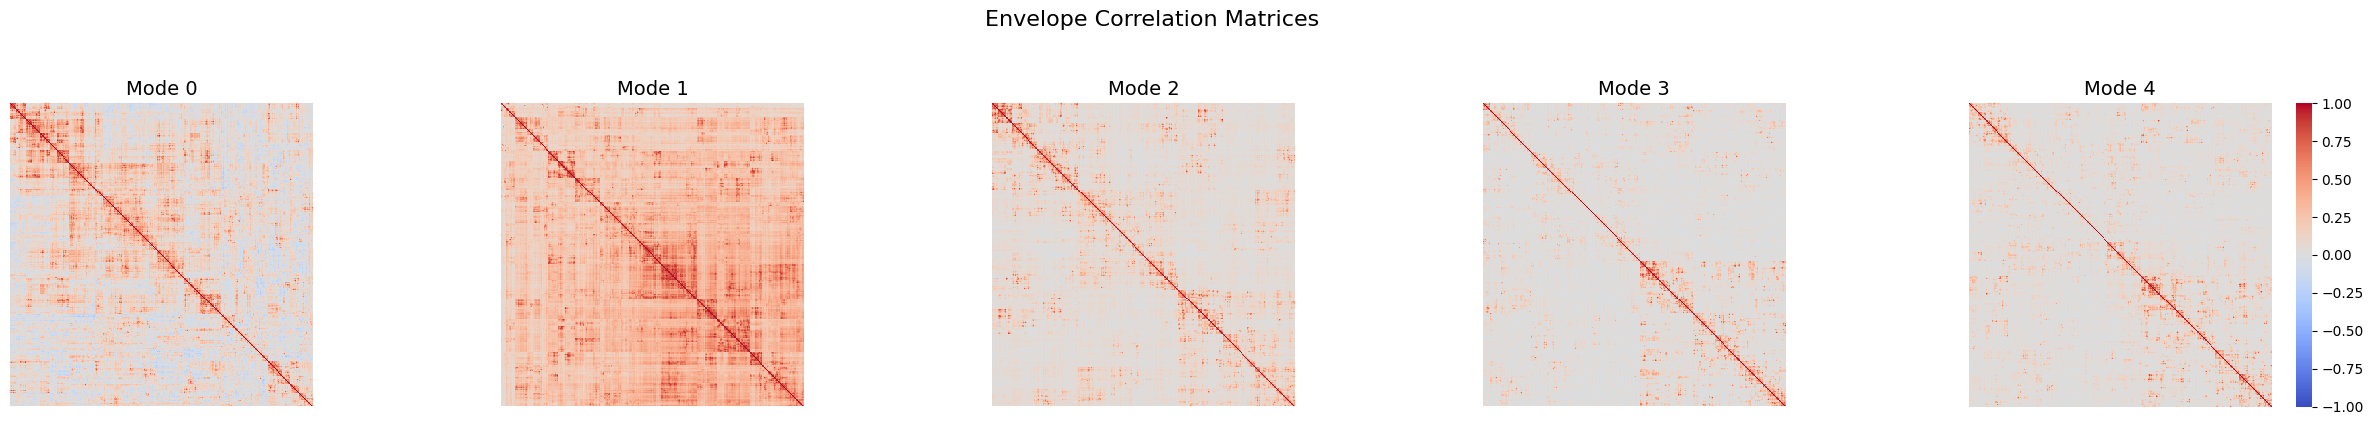

In [48]:
# Reordered the correlation matrices based on Hierarchical Clustering

# Plot reordered matrices
mvmd_plot_correlation_matrix_enveloppe_reordered(correlation_matrices, mode_indices=[0, 1, 2, 3, 4])


##  **5. Results Summary:**


In [49]:



modes_df = build_modes_df_mvmd(
    u_path="../results/real/MVMD/modes/mvmd_modes_sub-01.npz",
    envelope_dir="../results/real/MVMD/envelopes",
    raw_path="../data/sub-01_ses-01_task-rest_proc-filt_raw.fif"  # optional
)


# Save the modes_df to a pickle file
modes_df.to_pickle("../results/real/MVMD/modes_df.pkl")
print("✅ modes_df saved to ../results/real/MVMD/modes_df.pkl")


Opening raw data file ../data/sub-01_ses-01_task-rest_proc-filt_raw.fif...
    Range : 34500 ... 116999 =    138.000 ...   467.996 secs
Ready.
✅ modes_df saved to ../results/real/MVMD/modes_df.pkl


In [52]:
modes_df

,channel,channel_name,mode_idx,signal,envelope
0,0,BIO001,0,"[-2.843621e-13, -2.8543108e-13, -2.8430432e-13...","[1.8991175277337236e-13, 1.949337501312709e-13..."
1,0,BIO001,1,"[1.1857855e-13, 1.09172145e-13, 9.490559e-14, ...","[2.2442224334863307e-14, 2.376410395234837e-14..."
2,0,BIO001,2,"[6.6796395e-14, 5.6515576e-14, 4.088599e-14, 1...","[4.6091633249889866e-14, 4.6866271985208235e-1..."
3,0,BIO001,3,"[2.1144913e-15, -1.7640684e-14, -2.3901067e-16...","[8.378910053578794e-15, 9.644070650849813e-15,..."
4,0,BIO001,4,"[7.540389e-15, -2.7545533e-14, 1.7473209e-14, ...","[6.803225060261981e-15, 7.87330761703323e-15, ..."
...,...,...,...,...,...
1525,305,MEG2511,0,"[2.0871878e-12, 2.0852417e-12, 2.0592928e-12, ...","[6.4400676631770626e-12, 6.4692457120429925e-1..."
1526,305,MEG2511,1,"[-1.5327405e-12, -1.47434e-12, -1.3825695e-12,...","[1.0758842818384129e-12, 1.0840844281295725e-1..."
1527,305,MEG2511,2,"[-1.982738e-13, -9.015896e-14, 5.3477337e-14, ...","[4.441028436923816e-13, 4.652122328856201e-13,..."
1528,305,MEG2511,3,"[-7.378038e-14, 2.7396752e-14, -1.2194662e-13,...","[1.8689066407732297e-13, 2.288417936049947e-13..."


In [ ]:
# modes_df = pd.read_pickle("../results/real/MVMD/modes_df.pkl")

## **4. MFA:**


In [50]:
scaling_ranges = [(6, 12)]
q_vals = np.arange(-3, 6)
summary_records = []
methods = ["VMD"]


📊 Processing mode_idx = 0


<Figure size 800x400 with 0 Axes>

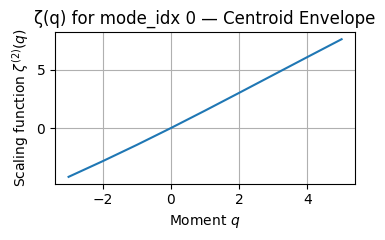

<Figure size 800x400 with 0 Axes>

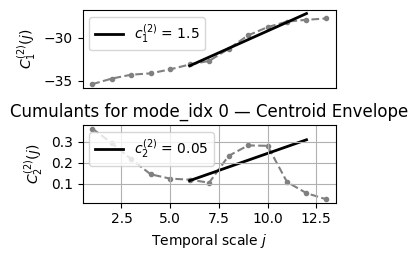

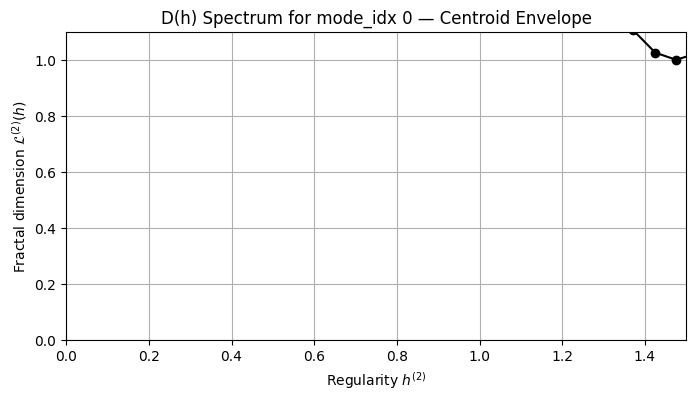


📊 Processing mode_idx = 1
❌ MFA failed for mode_idx 1: applied function returned data with an unexpected number of dimensions. Received 2 dimension(s) but expected 0 dimensions with names (), from:

array([[          nan],
       [          nan],
       [ 2.514529e-15],
       ...,
       [-7.048540e-15],
       [-5.808558e-15],
       [          nan]])

📊 Processing mode_idx = 2
❌ MFA failed for mode_idx 2: applied function returned data with an unexpected number of dimensions. Received 2 dimension(s) but expected 0 dimensions with names (), from:

array([[          nan],
       [          nan],
       [-3.488632e-16],
       ...,
       [-3.812461e-15],
       [ 2.496775e-17],
       [          nan]])

📊 Processing mode_idx = 3
❌ MFA failed for mode_idx 3: applied function returned data with an unexpected number of dimensions. Received 2 dimension(s) but expected 0 dimensions with names (), from:

array([[          nan],
       [          nan],
       [-2.346798e-16],
       ...,
  

In [51]:
summary_df = mfa_on_envelope_centroids(
    modes_df=modes_df,
    scaling_ranges=scaling_ranges,
    q_vals=q_vals,
    output_base="../results/real/MVMD/",
    group_by="mode_idx"
)
